In [2]:
import torch 
import torch.nn as tnn
from torchvision import datasets, transforms
import numpy as np

# Pytorch

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = datasets.MNIST("../data", train=True, download=True, transform=transform)
dataset_test = datasets.MNIST("../data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

model = tnn.Sequential(
  tnn.Flatten(),
  tnn.Linear(784, 30),
  tnn.ReLU(),
  tnn.Linear(30, 10),
  tnn.LogSoftmax(dim=1)
)

loss_fn = tnn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def test():
  model.eval()
  loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in test_loader:
      phat = model(x)
      loss += loss_fn(phat, y)
      yhat = phat.argmax(dim=1)
      correct += (yhat == y).sum().item()

  accuracy = correct / len(dataset_test)
  loss = loss / len(test_loader)
  print(f"Test results: Accuracy: {(100*accuracy):>0.2f}%, Avg loss: {loss:>8f} \n")

def train():
  model.train()
  for batch_idx, (x, y) in enumerate(train_loader):
      phat = model(x)
      loss = loss_fn(phat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch_idx % 300 == 0:
          print(f"{batch_idx*len(x):<7} ({batch_idx/len(train_loader):6.2%}) | Loss: {loss.item()}")

for epoch_idx in range(1):
  train()
  print(f"Epoch {epoch_idx+1} finished -------------------------------")
  test()

0       ( 0.00%) | Loss: 2.2906956672668457
9600    (16.00%) | Loss: 0.3466614782810211
19200   (32.00%) | Loss: 0.24585022032260895
28800   (48.00%) | Loss: 0.38877418637275696
38400   (64.00%) | Loss: 0.2634204924106598
48000   (80.00%) | Loss: 0.15904657542705536
57600   (96.00%) | Loss: 0.20051568746566772
Epoch 1 finished -------------------------------
Test results: Accuracy: 92.80%, Avg loss: 0.249014 



# Mine

In [4]:
from micrograd.core import Tensor 
import micrograd.nn as nn
from micrograd.data import DataLoader
import micrograd.optim

transform=transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,)),
])

dataset_train = datasets.MNIST("../data", train=True, download=True, transform=transform)
dataset_test = datasets.MNIST("../data", train=False, download=True, transform=transform)

train_data, train_labels = Tensor(dataset_train.data.unsqueeze(1).float()), Tensor(dataset_train.targets)
test_data, test_labels = Tensor(dataset_test.data.unsqueeze(1).float()), Tensor(dataset_test.targets)

train_loader = DataLoader(train_data, train_labels, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, test_labels, batch_size=32, shuffle=True)

model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 30),
  nn.ReLU(),
  nn.Linear(30, 10),
  nn.LogSoftmax(axis=1)
)

loss_fn = nn.NLLLoss()
optimizer = micrograd.optim.Adam(model.parameters(), lr=0.001)

def test():
  loss = 0
  correct = 0
  for x,y in test_loader:
    phat = model(x)
    loss += loss_fn(phat, y)
    yhat = np.argmax(phat.data, axis=-1)
    correct += (yhat == y.data).sum()

  accuracy = correct / len(test_data)
  loss = loss.item / len(test_loader)
  print(f"Test results: Accuracy: {(100*accuracy):>0.2f}%, Avg loss: {loss:>8f} \n")

def train():
  for batch_idx, (x,y) in enumerate(train_loader):
    phat = model(x)
    loss = loss_fn(phat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print(f"{batch_idx*len(x):<7} ({batch_idx/len(train_loader):6.2%}) | Loss: {loss.item}")
    
for epoch_idx in range(1):
  train()
  print(f"Epoch {epoch_idx+1} finished -------------------------------")
  test()

0       ( 0.00%) | Loss: 30.952191149259043
3200    ( 5.33%) | Loss: 0.8348068805231544
6400    (10.67%) | Loss: 0.5774931934804244
9600    (16.00%) | Loss: 0.7451822463030779
12800   (21.33%) | Loss: 0.7998439596002271
16000   (26.67%) | Loss: 0.27052465308542645
19200   (32.00%) | Loss: 0.744381569801664
22400   (37.33%) | Loss: 0.5302934905562356
25600   (42.67%) | Loss: 0.7442443411931808
28800   (48.00%) | Loss: 0.5539852994691964
32000   (53.33%) | Loss: 0.6439940043647778
35200   (58.67%) | Loss: 0.2606290365225196
38400   (64.00%) | Loss: 0.13374612963746746
41600   (69.33%) | Loss: 0.30204330735940466
44800   (74.67%) | Loss: 0.06230888313018922
48000   (80.00%) | Loss: 0.2759744641595271
51200   (85.33%) | Loss: 0.11511661953970538
54400   (90.67%) | Loss: 0.44403418904130265
57600   (96.00%) | Loss: 0.2373017530855429
Epoch 1 finished -------------------------------
Test results: Accuracy: 91.80%, Avg loss: 0.309489 



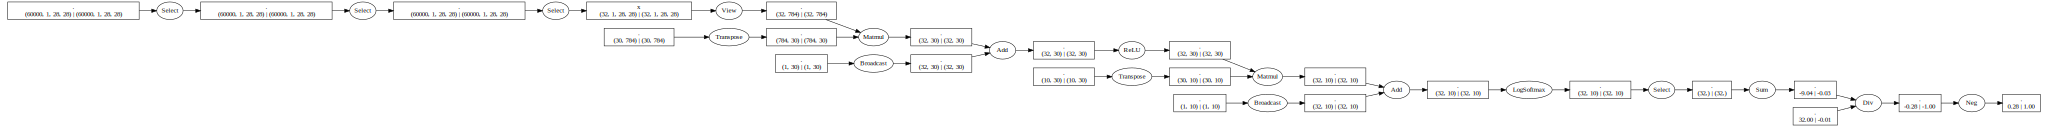

In [5]:
from micrograd.utils.graph import draw_graph

x, y = list(train_loader)[0]
x.name = "x"; y.name = "y"
loss = loss_fn(model(x), y)
loss.backward()
draw_graph(loss)